In [121]:
library(SingleCellExperiment)
library(scater)
library(limma)
options(stringsAsFactors = FALSE)

In [4]:
#Load data
#dset = 11

# Load the combined batches as one
#counts_prev <- read.table(
#    paste("/extra/sebastian_arnolds/analysis/trim/star_", dset, "/counts_matrix.tsv", sep=""),
#    sep="\t"
#)


counts_raw <- read.table(
    #paste("/extra/sebastian_arnolds/analysis/trim/star_", dset, "/counts_matrix.tsv", sep=""), 
    "/extra/sebastian_arnolds/analysis/trim/counts_matrix.tsv",
    sep="\t"
)

#barcodes_prev <- as.vector(
#    read.table(
#        paste("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_", dset, ".txt", sep="")
#    )[, 1])

barcodes_vector <- as.vector(
    read.table(
        #paste("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_", dset, ".txt", sep="")
        "/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_all.txt"
    )[, 1])

In [5]:
count_matrix <- as.matrix(counts_raw[, barcodes_vector])
dim(count_matrix)

[1] 21070   192

In [6]:
#head(counts_raw)
#message(dim(counts_prev), " → ", dim(counts_raw), " % ", 100*dim(counts_prev)/dim(counts_raw) )
#message(length(barcodes_prev), " → ", length(barcodes_vector), " % ", 100*length(barcodes_prev)/length(barcodes_vector))

In [7]:
# Change labels for genes of interest
name_map = list(
    ENSMUSG00000062327 = "Brachyury",
    ENSMUSG00000032446 = "Eomes",
    ENSMUSG00000030544 = "Mesp1",
    ENSMUSG00000024406 = "Pou5f1",
    ENSMUSG00000012396 = "nanog",
    ENSMUSG00000096014 = "Sox1",
    ENSMUSG00000074637 = "Sox2",
    ENSMUSG00000090125 = "Pou3f1",
    ENSMUSG00000060206 = "zfp462",
    ENSMUSG00000031297 = "slc7a3"
)

for (i in 1:length(name_map)){
    old_gene_name <- names(name_map[i])
    new_gene_name <- name_map[[i]]
    #message(old_gene_name, "→", new_gene_name)
    rownames(count_matrix)[which(rownames(count_matrix) == old_gene_name)] <- new_gene_name
}

In [8]:
# Check our matrix and our relabelled genes
head(count_matrix)

genes_of_interest <- !grepl("^ENS", rownames(count_matrix))
goi_matrix <- count_matrix[genes_of_interest,]


message(length(barcodes_vector), " barcodes → ", 
        dim(count_matrix)[2], " cells")

message(dim(count_matrix)[1], " genes → ", 
       dim(goi_matrix)[1], " main genes of interest")

,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG,ACCAAC,⋯,AGCGAA,GGTTAG,GATTGC,CGTTCA,ATCCGA,GCATTC,CCTGAA,GGAATC,TCAACG,AACACC
ENSMUSG00000000001,0,3,2,2,5,7,6,2,0,9,⋯,2,2,4,6,8,10,5,5,3,0
ENSMUSG00000000028,0,0,1,0,0,0,1,0,0,2,⋯,0,0,0,1,1,2,3,0,0,0
ENSMUSG00000000031,0,0,0,0,3,2,1,1,0,0,⋯,3,0,2,167,0,4,8,3,159,1
ENSMUSG00000000037,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000056,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSMUSG00000000058,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


192 barcodes → 192 cells
21070 genes → 9 main genes of interest


In [69]:
# Initialise single cell object -- we assume UMI counts from hereon out
sce <- SingleCellExperiment(assays = list(counts = count_matrix))
head(counts(sce))

sce <- getBMFeatureAnnos(
    sce, 
    filters = "ensembl_gene_id", 
    attributes = c("ensembl_gene_id", "external_gene_name"), 
    feature_symbol = "mgi_symbol",
    feature_id = "ensembl_gene_id",
    biomart = "ENSEMBL_MART_ENSEMBL",
    dataset = "mmusculus_gene_ensembl", 
    host = "www.ensembl.org"
)

,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG,ACCAAC,⋯,AGCGAA,GGTTAG,GATTGC,CGTTCA,ATCCGA,GCATTC,CCTGAA,GGAATC,TCAACG,AACACC
ENSMUSG00000000001,0,3,2,2,5,7,6,2,0,9,⋯,2,2,4,6,8,10,5,5,3,0
ENSMUSG00000000028,0,0,1,0,0,0,1,0,0,2,⋯,0,0,0,1,1,2,3,0,0,0
ENSMUSG00000000031,0,0,0,0,3,2,1,1,0,0,⋯,3,0,2,167,0,4,8,3,159,1
ENSMUSG00000000037,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000056,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSMUSG00000000058,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Warning message in is.na(feature_info_full$feature_symbol):
“is.na() applied to non-(list or vector) of type 'NULL'”

In [70]:
# Filter out any genes not found in any cell
genes_summed_gt_zero <- rowSums(counts(sce) > 0)
gene_names_gt_zero <- (genes_summed_gt_zero > 0)

# apply
sce_f <- sce[gene_names_gt_zero,]

# Check to see if we lost our genes of interest
genes_of_interest <- !grepl("^ENS", rownames(sce_f))

message(length(sce), " genes → ", length(sce_f), " detected genes, (", 
        length(sce) - length(sce_f), " filtered out), (",
        length(sce_f[genes_of_interest,]), " genes of interest still remaining)"
        )

sce <- sce_f # reassign

21070 genes → 20662 detected genes, (408 filtered out), (9 genes of interest still remaining)


In [71]:
# Spike-ins used?
# 
non_ENS <- !grepl("^ENS", rownames(sce))
non_goi <- rownames(sce) %in% rownames(goi_matrix)

message("Spike-ins detected = ", length(rownames(sce[non_ENS && !non_goi,])))

Spike-ins detected = 0


In [72]:
# Assign known/related groups
is.meso <- rownames(sce) %in% c("Eomes", "Brachyury", "Mesp1")
is.pluri <- rownames(sce) %in% c("Pou5f1", "nanog")
is.neuro <- rownames(sce) %in% c("Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3")

rowData(sce)$is_mesoderm <- is.meso
rowData(sce)$is_pluripotenz <- is.pluri
rowData(sce)$is_neuroectoderm <- is.neuro

# Assign known/related cell batches
colData(sce)$plate_number <- c(rep("plate1", 96), rep("plate2", 96)) 
# can we be sure of ordering...?



FALSE  TRUE 
  121    71 

37% of cells contain less than 8000 counts


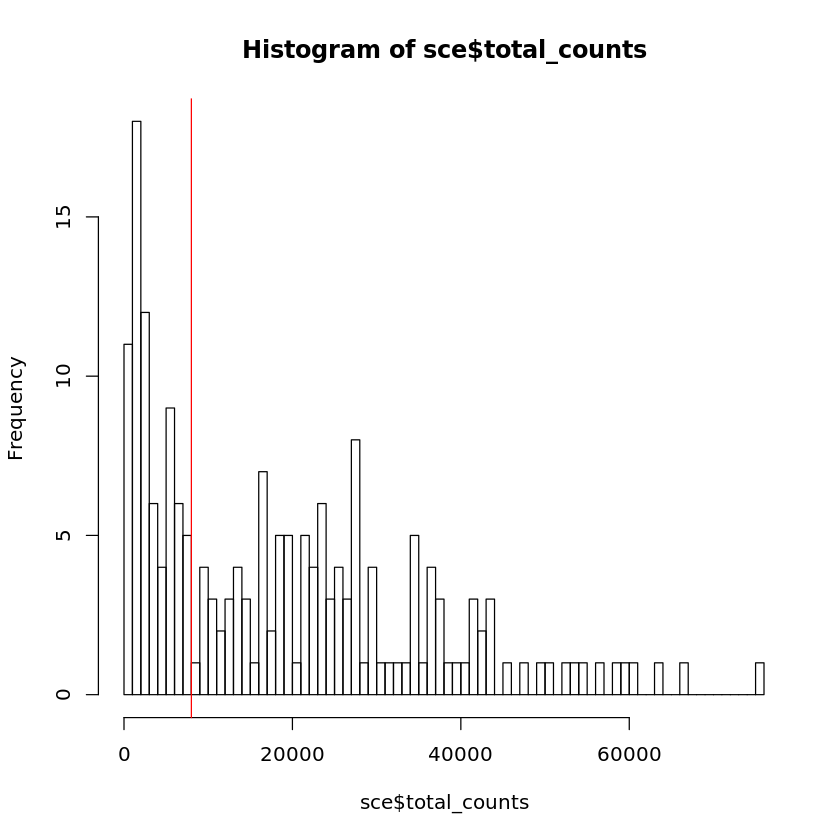

Most cells have between either 300-1700, or 5000-7000 detected genes

This is not related to the two different plates that the cells were loaded in, since the same profile is observed when using data from just one plate
(see: 2_postanal_lowres_singlebatch)


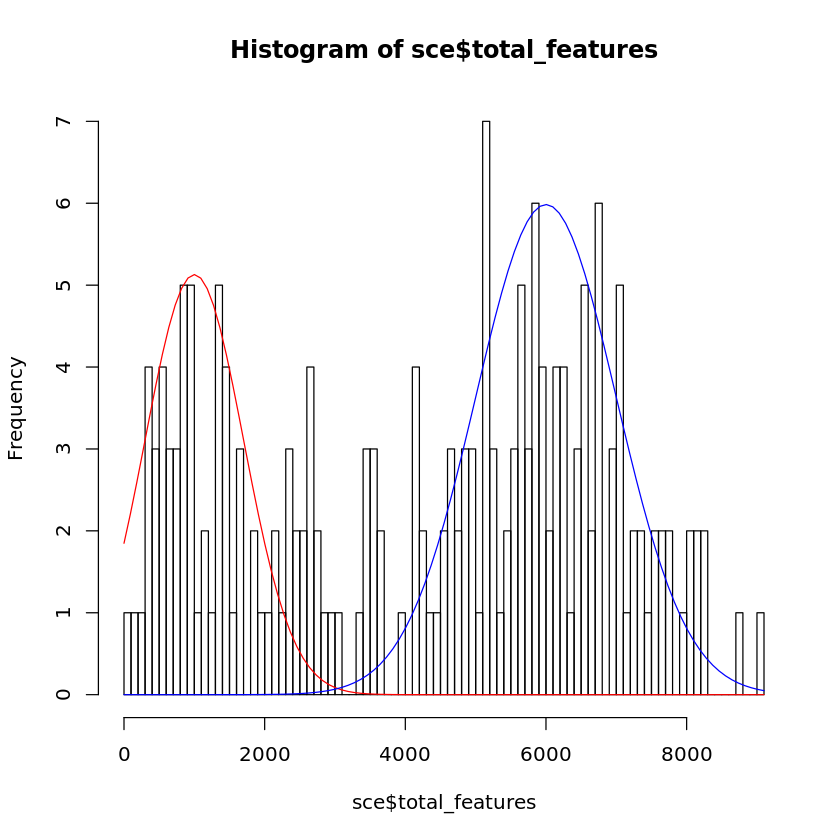

In [73]:
# Assign and calc some QC slots
sce <- calculateQCMetrics(sce)

#names(colData(sce))
lc_thresh = 8000
hist(sce$total_counts, breaks=100)
abline(v=lc_thresh, col="red")

# !! 
# For now we will assume wells with low read-depth are of poor quality. We will likely
# return to this filtering step later if we cannot find any signal in the downstream analysis.
# !!
table(sce$total_counts <= lc_thresh)
perc <- 100  * sum(sce$total_counts <= lc_thresh) / length(sce$total_counts)

message(sprintf("%.0f%% of cells contain less than %.0f counts", perc, lc_thresh))




# Let us also assume 
hist(sce$total_features, breaks = 100)
curve(dnorm(x, 1000, 700) * 9000, col = "red", add = TRUE)
curve(dnorm(x, 6000, 1000) * 15000, col = "blue", add = TRUE)

message("Most cells have between either 300-1700, or 5000-7000 detected genes\n")
message("This is not related to the two different plates that the cells were loaded in, since the same profile is observed when using data from just one plate")
message("(see: 2_postanal_lowres_singlebatch)")



In [125]:
#### BRANCH POINT: Filter out low-covered cells, and lowly expressed genes
# This will restrict our analysis to more widely expressed genes
# and will make it easier to normalise our library

# Manual filtering parameters below:

gf_thresh = 3000

sce$filter_welldef <- (
    sce$total_counts > lc_thresh
)

sce$filter_notwelldef <- (
    sce$total_counts <= lc_thresh
)

# Here we will filter out cells with counts <= lc_thresh, and  genes <= 3000
# -- looking for common well-defined features
sce$filter_welldef_highgenes <- (
    sce$total_counts > lc_thresh &
    sce$total_features > gf_thresh
)

# Here we will filter out cells with counts <= lc_thresh, and  genes > 3000
# -- looking for rare well-defined features
sce$filter_welldef_lowgenes <-(
    sce$total_counts > lc_thresh &
    sce$total_features <= gf_thresh
)

# Here we will filter out cells with a low selection of unique genes
# -- looking for common genes
sce$filter_highgenes <- (
    sce$total_features > gf_thresh
)

# Here we will filter out cells with a high selection of unique genes
# -- looking for rare genes
sce$filter_lowgenes <- (
    sce$total_features <= gf_thresh
)

message("Num. cells with a high seq depth = ", sum(sce$filter_welldef))
message("Num. cells with a low seq depth = ", sum(sce$filter_notwelldef))
message("Num. cells with a small selection of unique genes = ", sum(sce$filter_lowgenes))
message("Num. cells with a high selection of unique genes = ", sum(sce$filter_highgenes))
message("Num. cells with a small selection of unique genes and high seq depth = ", sum(sce$filter_welldef_lowgenes))
message("Num. cells with a high selection of unique genes and high seq depth = ", sum(sce$filter_welldef_highgenes))


Num. cells with a high seq depth = 121
Num. cells with a low seq depth = 71
Num. cells with a small selection of unique genes = 69
Num. cells with a high selection of unique genes = 123
Num. cells with a small selection of unique genes and high seq depth = 0
Num. cells with a high selection of unique genes and high seq depth = 121


Notice that the automatic outlier detection is in accordance with our assumption that most of
the outlier cells will have a smaller selection of unique genes


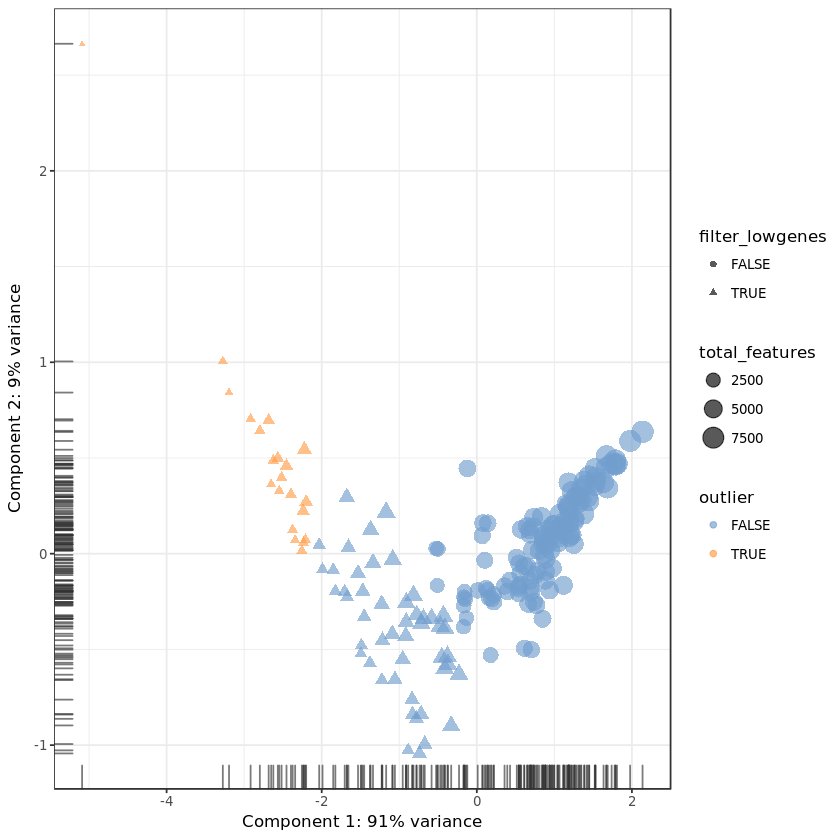

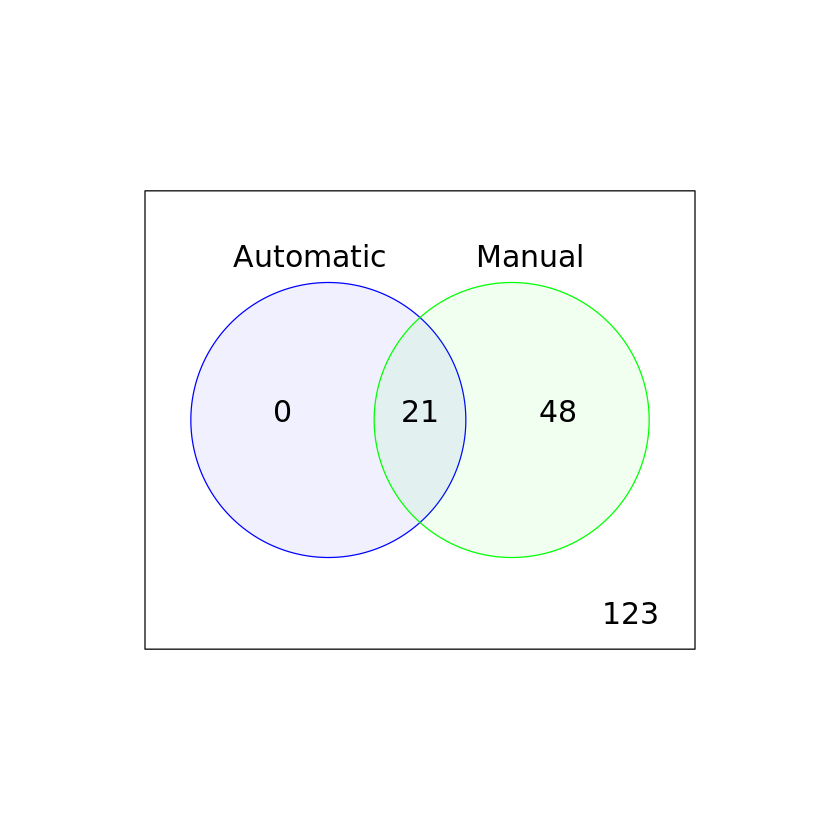

In [127]:
# Automatic filtering params below:
#  -- We shape by filter_lowgenes to see if our manual estimate is good
#     This does not affect the outlier detection

sce <- plotPCA(
    sce,
    size_by = "total_features", 
    shape_by = "filter_lowgenes",
    pca_data_input = "pdata",
    detect_outliers = TRUE,
    return_SCE = TRUE
)

message("Notice that the automatic outlier detection is in accordance with our assumption that most of
the outlier cells will have a smaller selection of unique genes")

## Outlier detection is the same for all below, no need to plot all here.

#p1 <- plotPCA(
#    sce,
#    size_by = "total_features", 
#    shape_by = "filter_welldef_highgenes",
#    pca_data_input = "pdata",
#    detect_outliers = TRUE,
#    return_SCE = TRUE
#)###
#
#p2 <- plotPCA(
#    sce,
#    size_by = "total_features", 
#    shape_by = "filter_highgenes",
#    pca_data_input = "pdata",
#    detect_outliers = TRUE,
#    return_SCE = TRUE
#)
#
#p2 <- plotPCA(
#    sce,
#    size_by = "total_features", 
#    shape_by = "filter_lowgenes",
#    pca_data_input = "pdata",
#    detect_outliers = TRUE,
#    return_SCE = TRUE
#)

# Let's see what the overlap is, and how sensitive.
auto <- colnames(sce)[sce$outlier]
man <- colnames(sce)[sce$filter_lowgenes]

venn.diag <- vennCounts(
    cbind(colnames(sce) %in% auto,
    colnames(sce) %in% man)
)
vennDiagram(
    venn.diag,
    names = c("Automatic", "Manual"),
    circle.col = c("blue", "green")
)


Overall flat distributions, hinting at good overall coverage


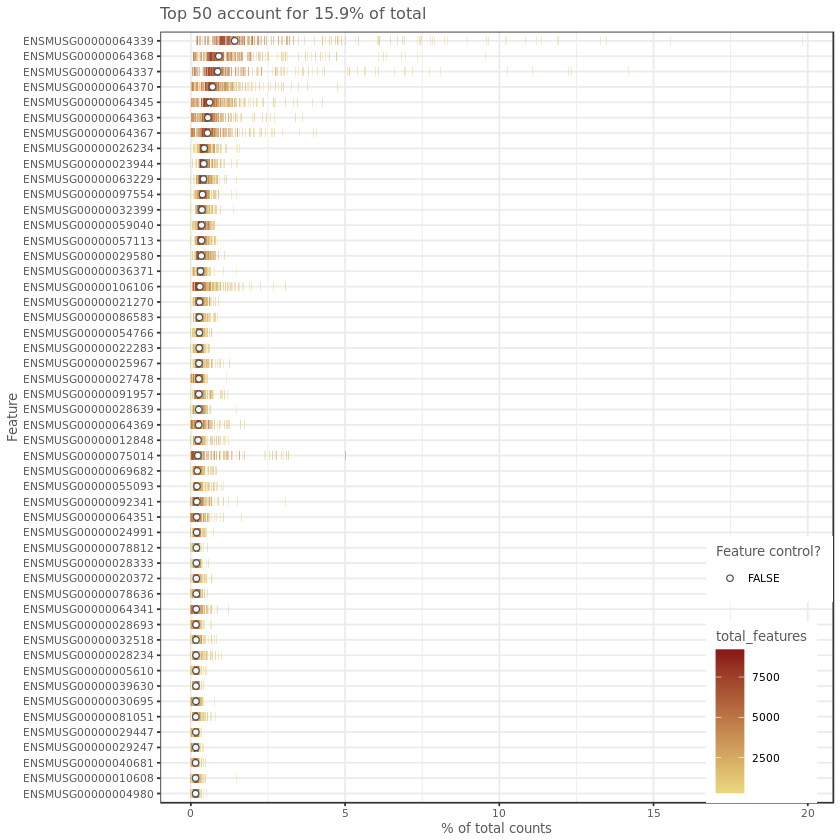

In [128]:
# Now let's examine the gene expression of the top 50 most expressive genes, 
# looking for any technical artefacts and an approximation of the coverage.

message("Overall flat distributions, hinting at good overall coverage")
message("No spike-ins or control genes to ")

plotQC(sce, type = "highest-expression")

